In [34]:
import torch
import torch.nn as nn
import optuna
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

## Loading Data

In [35]:
data = pd.read_csv('./data/lstm_disturbance.csv')
data

,Unnamed: 0,X,Y,Z,VX,VY,VZ,Roll,Pitch,Yaw,Rate Roll,Rate Pitch,Rate Yaw,Wind X,Wind Y,Wind Z,Disturbance X,Disturbance Y,Disturbance Z,Flight Num
0,0,0.000000,0.000000,30.000000,0.000112,0.000000,0.000000,0.000000,0.003559,0.000000,0.000000,0.711700,0.000000,-0.206787,0.075922,0.209785,-0.000000,-0.000000,-0.000000,0.0
1,1,0.000004,0.000000,30.000000,0.000894,0.000000,-0.000006,0.000000,0.012920,0.000000,0.000000,1.160480,0.000000,-0.206787,0.075922,0.209785,0.010403,-0.001394,-0.010567,0.0
2,2,0.000021,0.000000,30.000000,0.002785,0.000000,0.000007,0.000000,0.025862,0.000000,0.000000,1.427930,0.000000,-0.206787,0.075922,0.209785,0.010520,-0.001394,-0.010370,0.0
3,3,0.000064,0.000000,30.000000,0.006053,0.000000,0.000139,0.000000,0.040866,0.000000,0.000000,1.572990,0.000000,-0.206787,0.075922,0.209785,0.010598,-0.001394,-0.010100,0.0
4,4,0.000147,0.000000,30.000000,0.010841,0.000000,0.000387,0.000000,0.056937,0.000000,0.000000,1.640990,0.000000,-0.206787,0.075922,0.209785,0.010575,-0.001394,-0.009798,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179648,179648,0.056381,-5.040767,30.036978,0.076670,1.109080,0.301343,-0.263362,-0.067083,0.000185,0.011266,-0.000062,-0.000471,-5.384795,10.614886,0.245310,6.728735,-30.366681,-3.226134,25.0
179649,179649,0.057141,-5.029292,30.037048,0.076420,1.106080,0.300453,-0.263252,-0.067083,0.000185,0.011266,-0.000062,-0.000471,-5.380381,10.615899,0.245622,6.734904,-30.338292,-3.220790,25.0
179650,179650,0.057901,-5.017848,30.037119,0.076160,1.103080,0.299483,-0.263142,-0.067083,0.000185,0.011266,-0.000062,-0.000471,-5.375580,10.618424,0.248180,6.724248,-30.329309,-3.217753,25.0
179651,179651,0.058656,-5.006436,30.037189,0.075890,1.100090,0.298493,-0.263032,-0.067083,0.000185,0.011266,-0.000062,-0.000471,-5.379139,10.614927,0.247671,6.712262,-30.325120,-3.219040,25.0


In [36]:
data = data[::10] # 0.01 -> 0.1 s

First, change X, Y, Z into delta X,Y,Z

In [37]:
data['X'] = data['X'].diff()
data['Y'] = data['Y'].diff()
data['Z'] = data['Z'].diff()
data = data.dropna()

/tmp/ipykernel_2463580/1879319837.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['X'] = data['X'].diff()
/tmp/ipykernel_2463580/1879319837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Y'] = data['Y'].diff()
/tmp/ipykernel_2463580/1879319837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide

Next, subsample the data to only have points every 0.1 seconds (every 10 samples), at the same time build the time sequences and normalize the data.

In [38]:
def normalize_lstm_input(input):
    normalization = np.array([1.5, 1.5, 1.5, 15, 15, 15, np.pi/12, np.pi/12, np.pi/12])

    return input / normalization

In [39]:
grouped = data.groupby('Flight Num')
timestep = 10

sequenced_x = []
sequenced_y = []

for flight_num, flight_df in tqdm(grouped):
    x_data = flight_df[['X', 'Y', 'Z', 'VX', 'VY', 'VZ', 'Roll', 'Pitch', 'Yaw']]
    y_data = flight_df[['Disturbance X', 'Disturbance Y', 'Disturbance Z']]
    
    x_np = x_data.to_numpy()
    y_np = y_data.to_numpy()
    
    for i in range(0, x_np.shape[0]-timestep):
        curr_sequence = []
        for j in range(i, i+timestep):
            curr_sequence.append(normalize_lstm_input(x_np[j]))
            
        sequenced_x.append(curr_sequence)
        sequenced_y.append(y_np[i+timestep-1])

sequenced_y = np.array(sequenced_y)
sequenced_x = np.array(sequenced_x)

100%|██████████| 26/26 [00:00<00:00, 72.67it/s]


In [40]:
print(f'X shape: {sequenced_x.shape}, Y shape: {sequenced_y.shape}')

X shape: (17705, 10, 9), Y shape: (17705, 3)


In [41]:
# Make sure we are predicting the current point, not off by 1 somewhere
assert data.loc[100]['Disturbance X'] == sequenced_y[0][0]

## Training LSTM

In [42]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [43]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        
        out = self.fc(out[:, -1, :])
        return out

In [44]:
len(sequenced_x)* 0.9

15934.5

In [45]:
x_dim = sequenced_x[0][0].shape[0]
y_dim = sequenced_y[0].shape[0]

lstm = LSTM(x_dim, 64, 2, y_dim).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters(), lr=1e-4)

train_points = int(len(sequenced_x)*0.9)

X = torch.tensor(sequenced_x[:train_points], dtype=torch.float32)
y = torch.tensor(sequenced_y[:train_points], dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(X, y)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

losses = []
n_epochs = 100
for i in tqdm(range(n_epochs)):
    for (X, y) in dataloader:
        optimizer.zero_grad()
        X = X.to(device)
        y = y.to(device)
        preds = lstm(X)
        loss = criterion(y, preds)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:39<00:00,  2.50it/s]


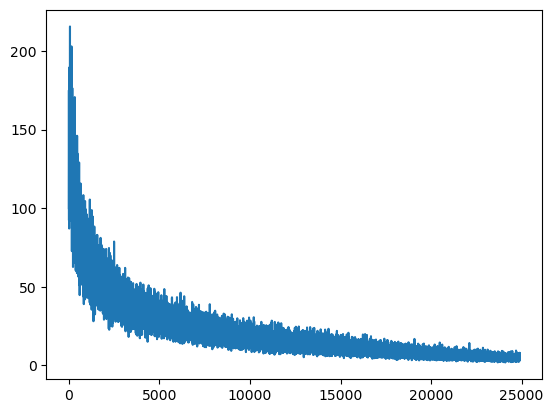

In [46]:
plt.plot(losses)

In [54]:
preds = []
ys = []

for x, y in zip(sequenced_x[train_points:], sequenced_y[train_points:]):
    x = torch.tensor(x, dtype=torch.float32).to(device).unsqueeze(0)
    pred = lstm(x)
    preds.append(pred.detach().cpu().numpy())
    ys.append(y)
    
preds = np.array(preds)
ys = np.array(ys)

In [55]:
preds.shape

(1771, 1, 3)

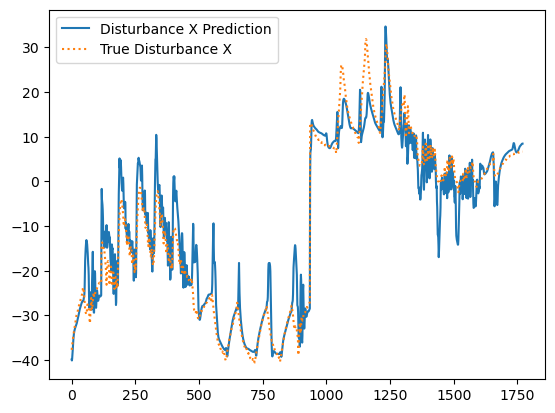

In [56]:
plt.plot(preds.squeeze()[:,0], label='Disturbance X Prediction')
plt.plot(ys[:,0], linestyle=':', label='True Disturbance X')
plt.legend()
# plt.xlim(0,1000)

This seems good enough for the RL agent!

In [ ]:
torch.save(lstm.state_dict(), './saved_models/lstm_disturbance.pth')